In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/job-titles/Job titles and industries.csv


In [2]:
#basic imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#NLP imports
import nltk
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import re

#Classification imports
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier,LogisticRegression

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from tqdm import tqdm
tqdm.pandas()
from sklearn.svm import SVC
# from keras.models import Sequential
# from keras.layers.recurrent import LSTM, GRU
# from keras.layers.core import Dense, Activation, Dropout
# from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
# from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
# from keras.preprocessing import sequence, text
# from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import tensorflow as tf

2021-09-20 17:36:24.735869: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-20 17:36:24.735998: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# <p style="background-color:skyblue; font-family:newtimeroman; font-size:250%; text-align:center; border-radius: 15px 50px;">Job title Classification by industry (Multi-text Text Classification Task)</p>
**My objective in this notebbok will be to ilustrate major concepts and steps in NLP modeling process as way of learning and deliver the knowelde for others**

## Dataset & Problem Formulation :
### Description:
You can think of the job industry as the category or general field in which
you work. On a job application, "industry" refers to a broad category under
which a number of job titles can fall. For example, sales is an industry; job
titles under this category can include sales associate, sales manager,
manufacturing sales rep, pharmaceutical sales and so on.

### Dataset:
The datasets contains a set of two columns ( Job title & Industry). the target column (industry) identifying the category of the given job title.

Our job is to create a ML model to to classify job titles by the industry.This is a classic case of a Multi Classification problem.


# 1- Loading Data 

In [5]:
data=pd.read_csv('../input/job-titles/Job titles and industries.csv')
data.head(10)

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT
5,privileged access management expert,IT
6,devops engineers x 3 - global brand,IT
7,devops engineers x 3 - global brand,IT
8,data modeller,IT
9,"php web developer £45,000 based in london",IT


In [6]:
print(data.shape)
print("\nThere are only ",len(data['job title'].unique()),"unique entries in job titles.")


(8586, 2)

There are only  3890 unique entries in job titles.


# 2- Basic EDA

In [7]:
from pandas_profiling import ProfileReport 

profile = ProfileReport( data, title='Pandas profiling report ' , html={'style':{'full_width':True}})

profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/15 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

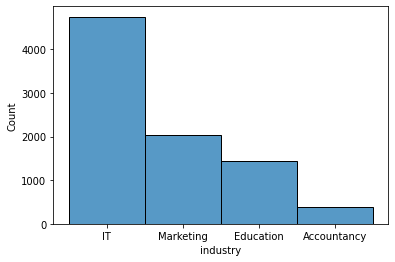

In [8]:
#Distribution of the Target Column:
sns.histplot(data['industry']);

**from the above figures : we can conclude the following :**

**1- There is a lot of duplicate values and this may lead to negative accuracy**

**2- The target data is imbalanced, we have to use oversampling techniques**

**3-There is no missing values , although there is some corrupted data (charachters) but this will be easy to deal during preprocessing process**

#  <a name="processing"></a> 3. Text Data Preprocessing



Before we start with any NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Some of the  basic text pre-processing techniques includes:

* Make text all **lower case** or **uppercase** so that the algorithm does not treat the same words in different cases as different
* **Removing Noise** i.e everything that isn’t in a standard number or letter i.e Punctuation, Numerical values,  common non-sensical text (/n)
* **Tokenization**: Tokenization is just the term used to describe the process of converting the normal text strings into a list of tokens i.e words that we actually want. Sentence tokenizer can be used to find the list of sentences and Word tokenizer can be used to find the list of words in strings.
* **Stopword Removal**: Sometimes, some extremely common words which would appear to be of little value in helping select documents matching a user need are excluded from the vocabulary entirely. These words are called stop words

### More data cleaning steps after tokenization:

* **Stemming**: Stemming is the process of reducing inflected (or sometimes derived) words to their stem, base or root form — generally a written word form. Example if we were to stem the following words: “Stems”, “Stemming”, “Stemmed”, “and Stemtization”, the result would be a single word “stem”.
* **Lemmatization**: A slight variant of stemming is lemmatization. The major difference between these is, that, stemming can often create non-existent words, whereas lemmas are actual words. So, your root stem, meaning the word you end up with, is not something you can just look up in a dictionary, but you can look up a lemma. Examples of Lemmatization are that “run” is a base form for words like “running” or “ran” or that the word “better” and “good” are in the same lemma so they are considered the same.
* Parts of speech tagging
* Create bi-grams or tri-grams
And more...

However, it is not necessary that you would need to use all these steps. The usage depends on your problem at hand.


Sometimes removal of stop words helps while at other times, this might not help.Here is a nice table taken from the blog titled : [All you need to know about Text Preprocessing for Machine Learning & NLP](https://kavita-ganesan.com/text-preprocessing-tutorial/#.Xi2BhhczZTY) that summarizes how much preprocessing you should be performing on your text data:

![](https://kavita-ganesan.com/wp-content/uploads/2019/02/Screen-Shot-2019-02-23-at-1.36.52-PM-590x270.png)

**In this notebook we will focus only on the main preprocessing techniques.**

In [9]:
df=data.copy()
df=df.drop_duplicates(subset="job title")

**Now let's take a look for our data after removing duplicates**

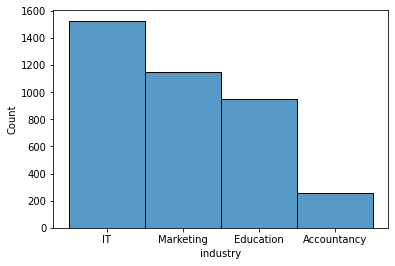

In [10]:

sns.histplot(df['industry']);

**Luckly for us some how this partially solve the problem!**

In [11]:
# from pandas_profiling import ProfileReport 

# profile = ProfileReport( data, title='Pandas profiling report ' , html={'style':{'full_width':True}})

# profile.to_notebook_iframe()

## 1. Data Cleaning

In [12]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
df['job title'] = df['job title'].apply(clean_text)


## 2. Stopwords Removal

Now, let's get rid of the stopwords i.e words which occur very frequently but have no possible value like **a, an, the, are **etc.

In [13]:
stop_words = stopwords.words('english')
more_stopwords = ['u', 'im', 'c']
stop_words = stop_words + more_stopwords

def remove_stopwords(text):
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    return text
    
df['job title'] = df['job title'].apply(remove_stopwords)

## 3. Tokenization

Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Base upon the type of tokens we want, tokenization can be of various types, for instance

In [14]:
# tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
# df['job title'] = df['job title'].apply(lambda x: tokenizer.tokenize(x))

# 4- Wordcloud & tokens Visualisation across different industries :
## Let's discover our data

In [15]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab
sentences = df["job title"].progress_apply(lambda x: x.split()).values
vocab = build_vocab(sentences)
print({k: vocab[k] for k in list(vocab)[:5]})

100%|██████████| 3890/3890 [00:00<00:00, 419021.07it/s]

{'technical': 72, 'support': 259, 'helpdesk': 17, 'supervisor': 34, 'county': 4}


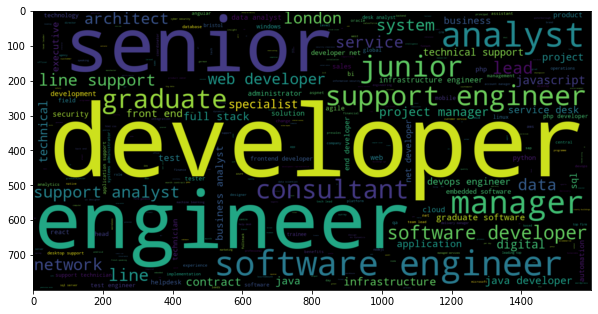

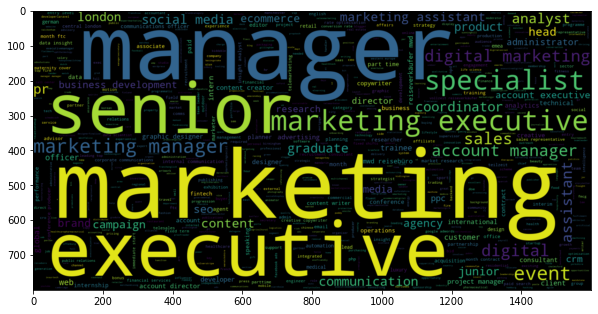

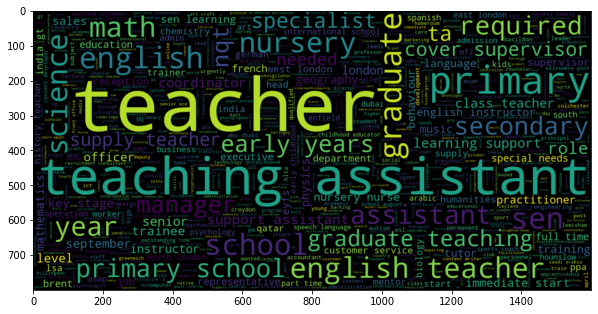

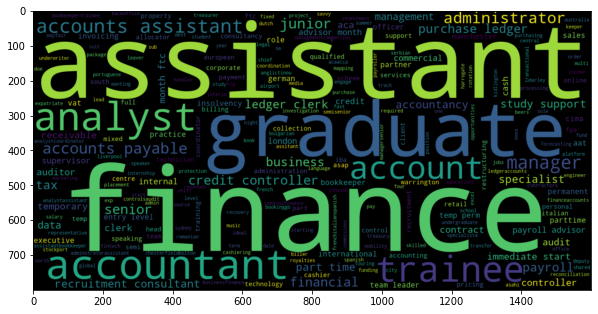

In [16]:
plt.figure(figsize = (10,9)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df['industry']=='IT']['job title']))
plt.imshow(wc,interpolation = 'bilinear' );
plt.figure(figsize = (10,9)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df['industry']=='Marketing']['job title']))
plt.imshow(wc , interpolation = 'bilinear')
plt.figure(figsize = (10,9)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df['industry']=='Education']['job title']))
plt.imshow(wc , interpolation = 'bilinear')
plt.figure(figsize = (10,9)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(df[df['industry']=='Accountancy']['job title']))
plt.imshow(wc , interpolation = 'bilinear')
plt.show();

# N-gram Analysis - Bigram and Trigram

In [17]:
from collections import Counter
counter = Counter(vocab)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'manager': 492,
 'marketing': 458,
 'developer': 405,
 'engineer': 389,
 'assistant': 351,
 'teacher': 328,
 'senior': 288,
 'analyst': 280,
 'support': 259,
 'executive': 254}

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

## **Unigram , Bigram & Trigram Analysis**

<AxesSubplot:>

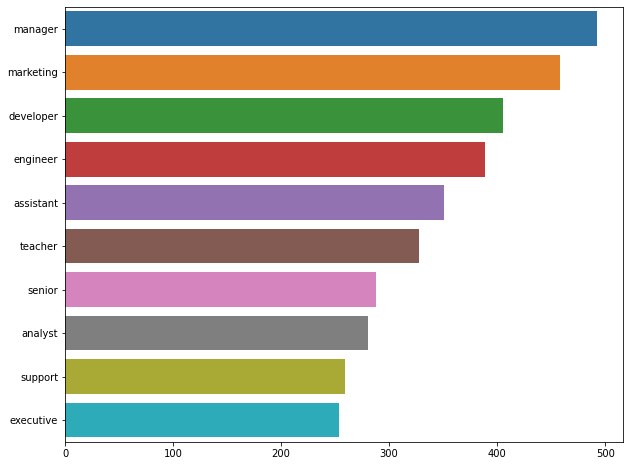

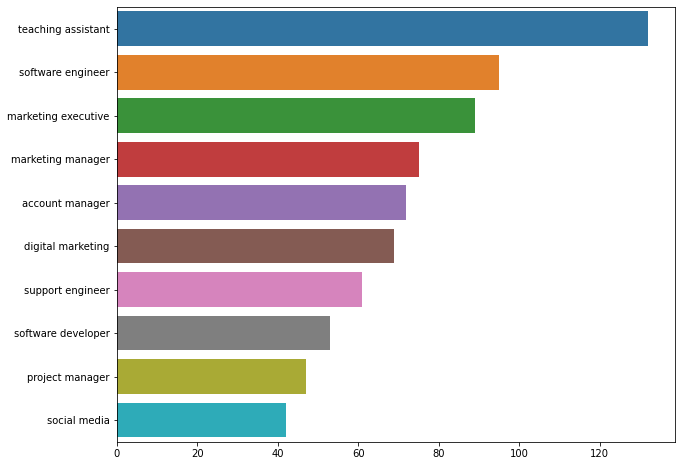

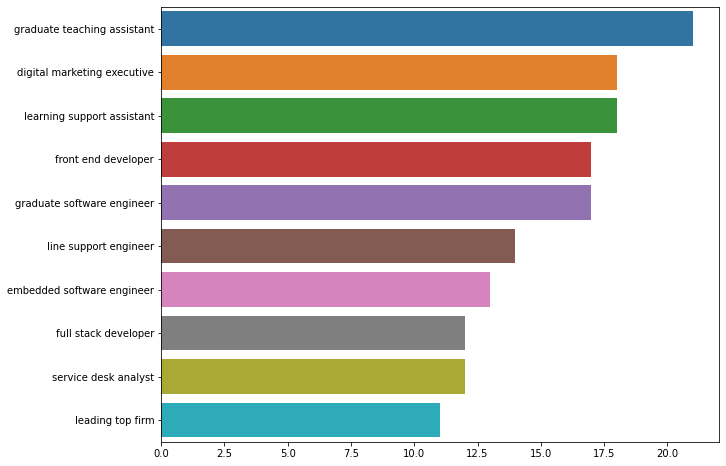

In [19]:
plt.figure(figsize = (10,8))
most_common_uni = get_top_text_ngrams(df['job title'],10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()))
plt.figure(figsize = (10,8))
most_common_bi = get_top_text_ngrams(df['job title'],10,2)
most_common_bi = dict(most_common_bi)
sns.barplot(x=list(most_common_bi.values()),y=list(most_common_bi.keys()))
plt.figure(figsize = (10,8))
most_common_tri = get_top_text_ngrams(df['job title'],10,3)
most_common_tri = dict(most_common_tri)
sns.barplot(x=list(most_common_tri.values()),y=list(most_common_tri.keys()))

# <a name="model"></a> 5- Building a Text Classification model
Now the data is ready to be fed into a classification model. Let's create a basic claasification model using commonly used classification algorithms and see how our model performs.

# Label Encoding :

In [20]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df['industry'])
X=df['job title']

## **Split Train/Test Set**

In [21]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, shuffle=True)

# Text Vectorization Methods

There are many methods to vctorize text, but in this notebook I will use only two of them:

## Countvectorizer

The [Scikit-Learn's CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary.

![](https://imgur.com/xxErhnB.png)

We take a dataset and convert it into a corpus. Then we create a vocabulary of all the unique words in the corpus. Using this vocabulary, we can then  create a feature vector of the count of the words.

## TF-IDF Vectorizer

![](https://imgur.com/J5lS7kX.png)

In the CountVectorizer, we use the counts of the words, in TFIDF we take the relative importance of that term in the entire corpus. TFIDF is composed of two words: TF and IDF. 
**TF** stands for the normalized  term frequency. Term Frequency is a scoring of the frequency of the word in the current document.`TF = (Number of times term t appears in a document)/(Number of terms in the document)`

**IDF** or Inverse Document Frequency: is a scoring of how rare the word is across documents. `IDF = 1+log(N/n)`, where N is the number of documents and n is the number of documents a term t has appeared in.TF-IDF weight is often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus





In [22]:
tfv = TfidfVectorizer()

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xtest))
xtrain_tfv =  tfv.transform(xtrain) 
xtest_tfv = tfv.transform(xtest)

In [23]:
ctv = CountVectorizer()

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xtest))
xtrain_ctv =  ctv.transform(xtrain) 
xtest_ctv = ctv.transform(xtest)

## TF-IDF Vectorizer Scores

In [24]:
lg = LogisticRegression(C=1.0)
NB = MultinomialNB()
svc = SVC(C=5)
xgb = xgb.XGBClassifier()

models = {"Linear Regression" : lg,
         "Naive Bayes" : NB ,
         "SVC" : svc,
         "XGB" : xgb}


columns = ['Classifier', 'score-rtv']

df_scores_cat = pd.DataFrame(columns=columns)
for name, model in models.items():
    model.fit(xtrain_tfv, ytrain)
    Y_predicted = model.predict(xtest_tfv)
    score = accuracy_score(ytest, Y_predicted)
    df_row = pd.DataFrame([[name, score]], columns=columns)
    df_scores_cat = df_scores_cat.append(df_row, ignore_index=True)

df_scores_cat.sort_values(by=['score-rtv'],ascending=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,score-rtv
2,SVC,0.885604
0,Linear Regression,0.876607
1,Naive Bayes,0.857326
3,XGB,0.844473


## Count Vectorizer Scores 

In [25]:
columns = ['Classifier', 'score-ctv']

df_scores_cat = pd.DataFrame(columns=columns)
for name, model in models.items():
    model.fit(xtrain_ctv, ytrain)
    Y_predicted = model.predict(xtest_ctv)
    score = accuracy_score(ytest, Y_predicted)
    df_row = pd.DataFrame([[name, score]], columns=columns)
    df_scores_cat = df_scores_cat.append(df_row, ignore_index=True)

df_scores_cat.sort_values(by=['score-ctv'],ascending=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,score-ctv
2,SVC,0.881748
1,Naive Bayes,0.872751
0,Linear Regression,0.867609
3,XGB,0.856041


# Model Evaluation
**Choosing Accuracy score metric for multiclass classification may be tricky specially when we are dealing with imbalanced data**

## Understanding the Evaluation Metric

Evaluation metrics are used to measure the quality of the statistical or machine learning model.There are many different types of evaluation metrics available to test a model. These include classification accuracy, logarithmic loss etc. For this particluar problem, our submissions will be evaluated using **F1** between the predicted and expected answers. 

The **F score**, also called the **F1 score** or **F measure**, is a measure of a test’s accuracy. 

The F score is defined as the weighted harmonic mean of the test’s precision and recall. 

![](https://imgur.com/nC4QwrO.png)

- Precision, also called the positive predictive value, is the proportion of positive results that truly are positive. 

- Recall, also called sensitivity, is the ability of a test to correctly identify positive results to get the true positive rate. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/350px-Precisionrecall.svg.png)
*source:https://en.wikipedia.org/wiki/Precision_and_recall*

The  F score reaches the best value, meaning perfect precision and recall, at a value of 1. The worst F score, which means lowest precision and lowest recall, would be a value of 0. 


**Classification Report & F1 Score for best two models:**

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
classes=np.array(data['industry'].unique())
svc.fit(xtrain_tfv, ytrain)
Y_predicted = model.predict(xtest_tfv)
print(classification_report(ytest,Y_predicted,target_names=classes))

              precision    recall  f1-score   support

          IT       0.88      0.69      0.77        52
   Marketing       0.85      0.90      0.87       191
   Education       0.87      0.87      0.87       305
 Accountancy       0.84      0.84      0.84       230

    accuracy                           0.86       778
   macro avg       0.86      0.82      0.84       778
weighted avg       0.86      0.86      0.86       778



In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
NB.fit(xtrain_ctv, ytrain)
Y_predicted = model.predict(xtest_ctv)
print(classification_report(ytest,Y_predicted,target_names=classes))

              precision    recall  f1-score   support

          IT       0.86      0.69      0.77        52
   Marketing       0.85      0.90      0.87       191
   Education       0.87      0.87      0.87       305
 Accountancy       0.84      0.84      0.84       230

    accuracy                           0.86       778
   macro avg       0.85      0.82      0.84       778
weighted avg       0.86      0.86      0.86       778



**look's like we have done good work so far. So, let's see how we can improve our model and deal with imbalanced data**

# Oversampling with SMOTE and ADASYN

## Oversampling with SMOTE

The SMOTE algorithm is one of the first and still the most popular algorithmic approach to generating new dataset samples. The algorithm, introduced and accessibly enough described in a [2002 paper](https://www.jair.org/media/953/live-953-2037-jair.pdf), works by oversampling the underlying dataset with new synthetic points.

The SMOTE algorithm is parameterized with `k_neighbors`  (the number of nearest neighbors it will consider) and the number of new points you wish to create. Each step of the algorithm will:

1. Randomly select a minority point.
2. Randomly select any of its `k_neighbors` nearest neighbors belonging to the same class.
3. Randomly specify a lambda value in the range `[0, 1]`.
4. Generate and place a new point on the vector between the two points, located lambda percent of the way from the original point.

The `imbalanced-learn` documentation includes the following illustration:

![](https://i.imgur.com/yrGAbiR.png)

## Let's see what we can do with this tichniques

In [28]:

tfv.fit(X)
x_m =tfv.transform(X)

<AxesSubplot:ylabel='Count'>

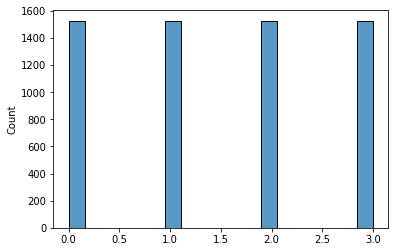

In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42 )
x_sm,y_sm = smote.fit_resample(x_m,y)

sns.histplot(y_sm)
             

In [30]:
x_train,x_test,y_train,y_test = train_test_split(x_sm, y_sm, test_size = 0.2 , stratify=y_sm ,random_state=42)

In [31]:
columns = ['Classifier', 'score-rtv']

df_scores_cat = pd.DataFrame(columns=columns)
for name, model in models.items():
    model.fit(x_train, y_train)
    Y_predicted = model.predict(x_test)
    score = accuracy_score(y_test, Y_predicted)
    df_row = pd.DataFrame([[name, score]], columns=columns)
    df_scores_cat = df_scores_cat.append(df_row, ignore_index=True)

df_scores_cat.sort_values(by=['score-rtv'],ascending=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,score-rtv
2,SVC,0.927228
0,Linear Regression,0.908422
1,Naive Bayes,0.907604
3,XGB,0.904334


In [32]:
svc.fit(x_train, y_train)
Y_predicted = model.predict(x_test)
print(classification_report(y_test, Y_predicted,target_names=classes))

              precision    recall  f1-score   support

          IT       0.99      0.95      0.97       306
   Marketing       0.88      0.95      0.91       305
   Education       0.90      0.86      0.88       306
 Accountancy       0.86      0.86      0.86       306

    accuracy                           0.90      1223
   macro avg       0.91      0.90      0.90      1223
weighted avg       0.91      0.90      0.90      1223



## Oversampling with ADASYN

The other oversampling technique implemented in `imlearn` is adaptive synthetic sampling, or ADASYN. ADASYN is similar to SMOTE, and derived from it, featuring just one important difference. it will bias the sample space (that is, the likelihood that any particular point will be chosen for duping) towards points which are located not in homogenous neighborhoods. Applied to our sample data, this results in the following:

<AxesSubplot:ylabel='Count'>

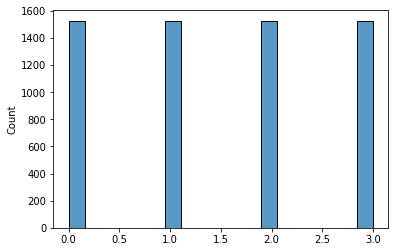

In [33]:
from imblearn.over_sampling import ADASYN
X_resampled, y_resampled = ADASYN().fit_resample(x_m,y)

sns.histplot(y_sm)

In [34]:
x_train,x_test,y_train,y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2 , stratify=y_resampled , random_state=42)

columns = ['Classifier', 'score-rtv']

df_scores_cat = pd.DataFrame(columns=columns)
for name, model in models.items():
    model.fit(x_train, y_train)
    Y_predicted = model.predict(x_test)
    score = accuracy_score(y_test, Y_predicted)
    df_row = pd.DataFrame([[name, score]], columns=columns)
    df_scores_cat = df_scores_cat.append(df_row, ignore_index=True)

df_scores_cat.sort_values(by=['score-rtv'],ascending=False)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:37:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,Classifier,score-rtv
2,SVC,0.945573
0,Linear Regression,0.906580
3,XGB,0.903331
1,Naive Bayes,0.887896


In [35]:
svc.fit(x_train, y_train)
Y_predicted = model.predict(x_test)
print(classification_report(y_test, Y_predicted,target_names=classes))

              precision    recall  f1-score   support

          IT       0.98      0.95      0.97       308
   Marketing       0.88      0.95      0.92       314
   Education       0.89      0.86      0.88       306
 Accountancy       0.86      0.84      0.85       303

    accuracy                           0.90      1231
   macro avg       0.90      0.90      0.90      1231
weighted avg       0.90      0.90      0.90      1231



## And we can see how our result improved!

# Choice of classifier 

I tried different classifiers (LinearSVC, Multinomial NaiveBayes, LR & XGB), each for the reason of experimenting and trying different approaches to discover what is best for my data. Multinomial NB is a good base for the problem, LinearSVC is regarded to be one of the best text classification algorithms and LR is a simple and easy to understand algorithm.

I chose my final model to be the highest in measure (F1 score) of those three classifiers which was LinearSVC. 

# Further Development: Better Performance & Limitations
My limitations are mostly in the data, although I tried to handle class imbalance with different techniques &removing  duplicates,we achieved great score but still the imbalanced data have the major effect on getting higher results.

misclassifying for classes with lower relative samples still occurs (My model would fail for this case). Normally The text classification problem is a problem that requires a lot of data. Those pretrained models achieving state of the art performance have millions and billions of words to play with.

For further improvements we can use embedding system and LSTM for text classification , but giving the size of the data and complixity we would not prefer to star with LSTM.
Also, there is alot of different oversampling , undersampling techniques and preprocessing techniques.
I only focued on the main categories to see the results.

# About Deploying the Model: Flask API
To test and use my Model's RESTful API service:
The Server only supoorts GET Requests.

The Server is run by simply running the script from terminal using command (python api_server.py)

After running the server you can direct GET requests to it using Postman or any other tool.

## Example Request/Response:
Request: "http://127.0.0.1:5000/model/api/JS NLP Engineer" (Job title added to request)

Response: "IT" (Predicted Industry by model)

In [36]:
from joblib import dump, load
dump(svc, 'model_final.joblib')

['model_final.joblib']